In [1]:
import tensorflow as tf 
import cv2 
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.models import Sequential
from keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/archive.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


# **PREPROCESSING**


---



In [2]:
Datadirectory = "train/"



In [3]:
Categories = ["angry", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"]

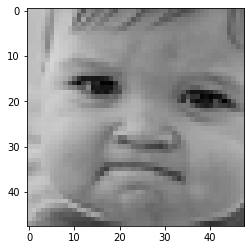

In [4]:
for category in Categories:
  path = os.path.join(Datadirectory, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img))
    plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
    plt.show()
    break
  break

<function matplotlib.pyplot.show(*args, **kw)>

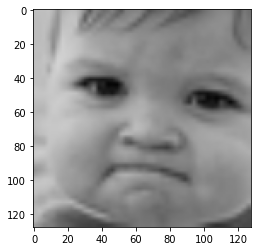

In [5]:
img_size = 128
newArray = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(newArray, cv2.COLOR_BGR2RGB))
plt.show

In [6]:
from types import new_class

training_Data = []
def create_training_data():
  for category in Categories:
    path = os.path.join(Datadirectory, category)
    class_num = Categories.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        newArray = cv2.resize(img_array, (img_size, img_size))
        training_Data.append([newArray, class_num])
      except Exception as e:
        pass

create_training_data()

In [7]:
X = []
y = []
for features, label in training_Data:

  X.append(features)
  y.append(label)


X = np.array(X).reshape(-1, img_size, img_size, 3)


In [ ]:
# norm = cv2.normalize(X, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# y = le.fit_transform(y)

In [10]:
X = X / 255.0

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=.2,random_state=0)

In [8]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True,
                                  #  rotation_range = 10,
                                  #  zoom_range = 0.1,
                                  #  validation_split = 0.2,
)

train_generator = datagen_train.flow_from_directory('train/',
                                                batch_size = 128,
                                                target_size=(128, 128),
                                                shuffle=True,
                                                color_mode='rgb',
                                                # subset = 'training',
                                                class_mode='categorical')


datagen_valid = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

valid_generator = datagen_train.flow_from_directory('train/',
                                                batch_size = 128,
                                                target_size=(128, 128),
                                                shuffle=True,
                                                color_mode='rgb',
                                                subset = 'validation',
                                                class_mode='categorical')

#sad 0000001
#happy 0000010
#angry 0000100

datagen_test = ImageDataGenerator(rescale=1./255)

test_generator = datagen_test.flow_from_directory('test/',
                                                batch_size = 128,
                                                target_size=(128, 128),
                                                shuffle=True,
                                                color_mode='rgb',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 0 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **MODEL BUILDING AND TRAINING**
# **VGG16 on FER2013**

---




In [15]:
new_model = Sequential()


model = tf.keras.applications.VGG16(include_top = False, input_shape = (128,128,3), weights = 'imagenet', pooling = 'avg')
# model = Model (inputs=model.inputs, outputs= model.layers [-2].output)

# for layer in model.layers:
#   layer.trainable = False


# for layer in range(173):
#   model.layers[layer].trainable = False

for layer in model.layers[:-5]:
  layer.trainable = False

model.summary()

# batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
# for i in range(170):
#     if i not in batch_norm_indices:
#         model.layers[i].trainable = False


new_model.add(model)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [16]:
from keras.regularizers import l2
# new_model.add(Dropout(0.5))
new_model.add(Flatten())
new_model.add(BatchNormalization())
new_model.add(Dropout(0.25))
new_model.add(Dense(64, kernel_regularizer=l2(0.01),activation='relu'))
new_model.add(BatchNormalization())
new_model.add(Dropout(0.25))
new_model.add(Dense(64, kernel_regularizer=l2(0.01), activation='relu'))
new_model.add(BatchNormalization())
new_model.add(Dropout(0.25))
# new_model.add(Dense(64, kernel_regularizer=l2(0.01), activation='relu'))
# new_model.add(BatchNormalization())
# new_model.add(Dropout(0.25))
# new_model.add(Dense(512, kernel_regularizer=l2(0.01), activation='relu'))
# new_model.add(BatchNormalization())
# new_model.add(Dropout(0.25))
# new_model.add(Dense(256, activation='relu'))
# new_model.add(Dropout(0.4))
# new_model.add(Dense(64, activation='relu'))
# new_model.add(Dropout(0.2))
new_model.add(Dense(7, activation='softmax'))

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 module_wrapper_6 (ModuleWra  (None, 512)              0         
 pper)                                                           
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 module_wrapper_7 (ModuleWra  (None, 512)              0         
 pper)                                                           
                                                                 
 module_wrapper_8 (ModuleWra  (None, 64)               32832     
 pper)                                                

In [17]:
from keras.optimizers import SGD
from keras.optimizers import Adam
adam = keras.optimizers.Adam(learning_rate=0.001)
opt = SGD(learning_rate=0.01)
sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.0001, nesterov=True)
new_model.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              verbose=1,
                              patience=5,
                              min_lr=0.000001,
                              min_delta=0.1,
                              factor=0.2
                             )

In [13]:
earlystopping = EarlyStopping(monitor='val_accuracy', 
                              mode='max', 
                              verbose=1, 
                              patience=50
                             )

In [ ]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

In [ ]:
import math
batch_size = 64
trainingsize = 28709   
validate_size = 7178  
def calculate_spe(y):
  return int(math.ceil((1. * y) / batch_size)) 


steps_per_epoch = calculate_spe(trainingsize)
validation_steps = calculate_spe(validate_size)

In [18]:
history = new_model.fit(train_generator, validation_data = test_generator, shuffle = True, epochs = 100, callbacks=[reduce_lr, earlystopping])

Epoch 1/100
225/225 [==============================] - 62s 269ms/step - loss: 1.6518 - accuracy: 0.3969 - val_loss: 1.3685 - val_accuracy: 0.4824 - lr: 0.0010
Epoch 2/100
225/225 [==============================] - 60s 265ms/step - loss: 1.2871 - accuracy: 0.5126 - val_loss: 1.3252 - val_accuracy: 0.4967 - lr: 0.0010
Epoch 3/100
225/225 [==============================] - 60s 266ms/step - loss: 1.1758 - accuracy: 0.5608 - val_loss: 1.1805 - val_accuracy: 0.5499 - lr: 0.0010
Epoch 4/100
225/225 [==============================] - 60s 267ms/step - loss: 1.1073 - accuracy: 0.5852 - val_loss: 1.1843 - val_accuracy: 0.5527 - lr: 0.0010
Epoch 5/100
225/225 [==============================] - 60s 265ms/step - loss: 1.0414 - accuracy: 0.6130 - val_loss: 1.0997 - val_accuracy: 0.5868 - lr: 0.0010
Epoch 6/100
225/225 [==============================] - 60s 266ms/step - loss: 0.9920 - accuracy: 0.6335 - val_loss: 1.2432 - val_accuracy: 0.5261 - lr: 0.0010
Epoch 7/100
225/225 [=========================

In [19]:
score = new_model.evaluate(test_generator)

57/57 [==============================] - 11s 190ms/step - loss: 1.2876 - accuracy: 0.6510


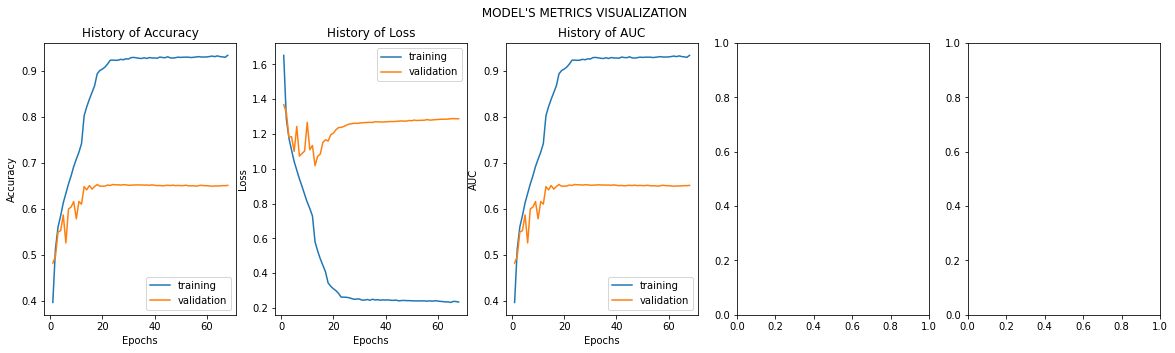

In [20]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    

    plt.show()

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['accuracy'],history.history['val_accuracy']
              )

57/57 [==============================] - 11s 193ms/step
              precision    recall  f1-score   support

           0       0.12      0.13      0.13       958
           1       0.04      0.04      0.04       111
           2       0.12      0.11      0.12      1024
           3       0.24      0.24      0.24      1774
           4       0.17      0.17      0.17      1233
           5       0.18      0.19      0.19      1247
           6       0.11      0.11      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



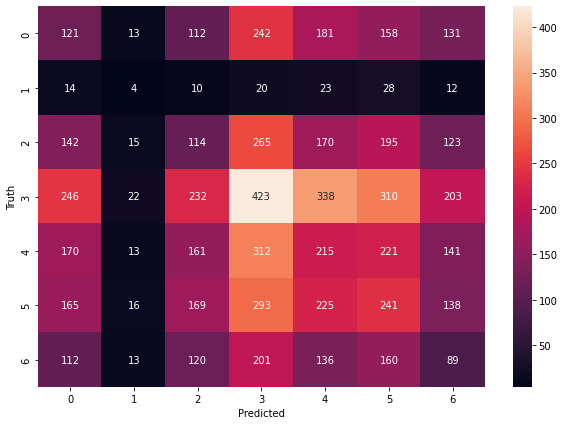

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def performance_metrics(model, test):
    y_pred = new_model.predict(test)
    y_result = []
    for p in y_pred:
        y_result.append(np.argmax(p))
    
    y_actual = []
    for i in range(len(test)):
        for p in test[i][1]:
            y_actual.append(np.argmax(p))
    
    print(classification_report(y_actual, y_result))
    
    
    cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

    plt.figure(figsize = (10, 7))
    sn.heatmap(cm, annot = True, fmt = 'd')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')


performance_metrics(new_model, test_generator)

In [ ]:
new_model.save('TrainedResNet50.h5')

In [ ]:
Loaded_model = keras.models.load_model('TrainedResNet50.h5')

In [ ]:
feature_extraction = new_model.predict(X_train)

In [ ]:
features = feature_extraction.reshape(feature_extraction.shape[0], -1)

# **SVM CLASSIFICATION**

---



In [ ]:
X_for_SVM = features

In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_for_SVM, Y_train)

SVC()

In [ ]:
X_Test_feature = new_model.predict(X_test)

180/180 [==============================] - 8s 47ms/step


In [ ]:
X_Test_New_Features = X_Test_feature.reshape(X_Test_feature.shape[0], -1)

In [ ]:
y_pred = clf.predict(X_Test_New_Features)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred)*100)

Accuracy: 97.91013584117032


# **CK+ Dataset**

---



In [ ]:
import tensorflow as tf 
import cv2 
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.models import Sequential
from keras.models import Model

In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/CK+.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
DatadirectoryCK = "CK+48/"

In [ ]:
CategoriesCK = ["anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]

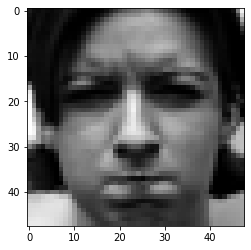

In [ ]:
for category in CategoriesCK:
  path = os.path.join(DatadirectoryCK, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img))
    plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
    plt.show()
    break
  break

<function matplotlib.pyplot.show(*args, **kw)>

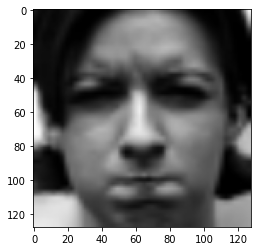

In [ ]:
img_size = 128
newArray = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(newArray, cv2.COLOR_BGR2RGB))
plt.show

In [ ]:
from types import new_class

training_DataCK = []
def create_training_data():
  for category in CategoriesCK:
    path = os.path.join(DatadirectoryCK, category)
    class_num = CategoriesCK.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        newArray = cv2.resize(img_array, (img_size, img_size))
        training_DataCK.append([newArray, class_num])
      except Exception as e:
        pass

create_training_data()

In [ ]:
XCK = []
yCK = []
for features, label in training_DataCK:

  XCK.append(features)
  yCK.append(label)


XCK = np.array(XCK).reshape(-1, img_size, img_size, 3)

In [ ]:
XCK = XCK / 255.0

In [ ]:
from sklearn.model_selection import train_test_split
X_trainCK,X_testCK,Y_trainCK,Y_testCK = train_test_split(XCK,yCK,test_size=.2,random_state=0)

In [ ]:
new_modelCK = Sequential()


modelCK = tf.keras.applications.VGG16(include_top = False, input_shape = (128,128,3), weights = 'imagenet', pooling = 'avg')

# for layer in modelCK.layers:
#   layer.trainable = False


for layer in modelCK.layers[:-5]:
  layer.trainable = False


# model.summary()

# batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
# for i in range(170):
#     if i not in batch_norm_indices:
#         modelCK.layers[i].trainable = False


new_modelCK.add(modelCK)

In [ ]:
from keras.regularizers import l2
from tensorflow.keras import regularizers

new_modelCK.add(Flatten())
# new_modelCK.add(BatchNormalization())
# new_modelCK.add(Dropout(0.25))
new_modelCK.add(Dense(64,kernel_regularizer=l2(0.01), activation='relu'))
new_modelCK.add(BatchNormalization())
new_modelCK.add(Dropout(0.4))
new_modelCK.add(Dense(64,kernel_regularizer=l2(0.01), activation='relu'))
new_modelCK.add(BatchNormalization())
new_modelCK.add(Dropout(0.4))


# new_modelCK.add(Dense(64,kernel_regularizer=l2(0.01), activation='relu'))
# new_modelCK.add(BatchNormalization())
# new_modelCK.add(Dropout(0.25))
# new_modelCK.add(Dense(64,kernel_regularizer=l2(0.01), activation='relu'))
# new_modelCK.add(BatchNormalization())
# new_modelCK.add(Dropout(0.25))
new_modelCK.add(Dense(7, activation='softmax'))


In [ ]:
from keras.optimizers import SGD
from keras.optimizers import Adam
adam = keras.optimizers.Adam(learning_rate=0.0001)
opt = SGD(learning_rate=0.001)
new_modelCK.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(new_modelCK, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              verbose=1,
                              patience=10,
                              min_lr=0.000001,
                              min_delta=0.1,
                              factor=0.2
                             )

In [ ]:
earlystopping = EarlyStopping(monitor='val_accuracy', 
                              mode='max', 
                              verbose=1, 
                              patience=20
                             )

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True,
                                   rotation_range = 20,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   validation_split = 0.3)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.3)



In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/CK+48',
                                                   target_size = (128,128),
                                                   class_mode = 'categorical',
                                                   color_mode = 'rgb',
                                                   shuffle = True,
                                                   subset = 'training',
                                                   batch_size = 32)

Found 689 images belonging to 7 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/CK+48',
                                                  target_size = (128,128),
                                                  color_mode = 'rgb',
                                                  shuffle = True,
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 292 images belonging to 7 classes.


In [ ]:
historyCK = new_modelCK.fit(train_dataset, validation_data = valid_dataset, epochs = 100, callbacks=[reduce_lr, earlystopping], shuffle = True)

Epoch 1/100
22/22 [==============================] - 15s 583ms/step - loss: 1.9865 - accuracy: 0.3498 - val_loss: 1.8540 - val_accuracy: 0.2534 - lr: 1.0000e-04
Epoch 2/100
22/22 [==============================] - 13s 572ms/step - loss: 1.4306 - accuracy: 0.5065 - val_loss: 1.8420 - val_accuracy: 0.2534 - lr: 1.0000e-04
Epoch 3/100
22/22 [==============================] - 12s 561ms/step - loss: 1.2379 - accuracy: 0.5501 - val_loss: 1.6149 - val_accuracy: 0.3801 - lr: 1.0000e-04
Epoch 4/100
22/22 [==============================] - 13s 612ms/step - loss: 1.1306 - accuracy: 0.5951 - val_loss: 1.3945 - val_accuracy: 0.4726 - lr: 1.0000e-04
Epoch 5/100
22/22 [==============================] - 12s 567ms/step - loss: 0.9495 - accuracy: 0.6792 - val_loss: 1.0612 - val_accuracy: 0.6267 - lr: 1.0000e-04
Epoch 6/100
22/22 [==============================] - 13s 582ms/step - loss: 0.8739 - accuracy: 0.6807 - val_loss: 0.8979 - val_accuracy: 0.7363 - lr: 1.0000e-04
Epoch 7/100
22/22 [===============

In [ ]:
scoreCK = new_modelCK.evaluate(valid_dataset)

10/10 [==============================] - 3s 277ms/step - loss: 0.2419 - accuracy: 0.9247


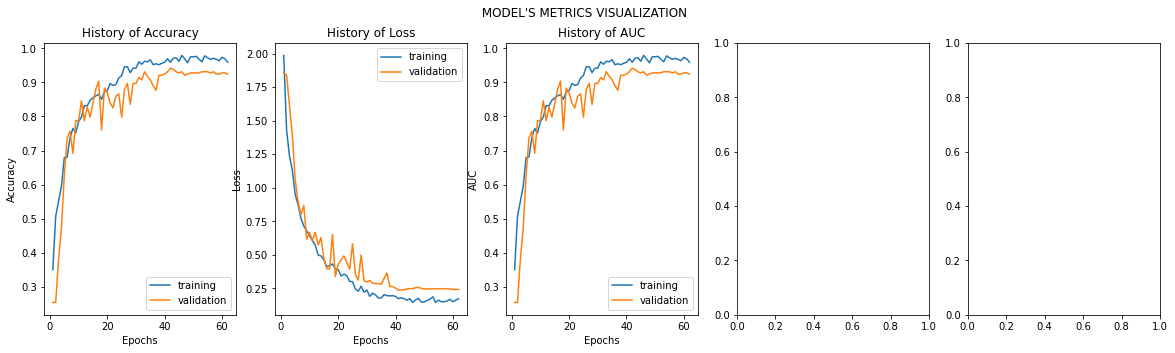

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    

    plt.show()
    

Train_Val_Plot(historyCK.history['accuracy'],historyCK.history['val_accuracy'],
               historyCK.history['loss'],historyCK.history['val_loss'],
               historyCK.history['accuracy'],historyCK.history['val_accuracy']
              )

In [ ]:
feature_extractionCK = new_modelCK.predict(X_trainCK)

25/25 [==============================] - 8s 305ms/step


In [ ]:
featuresCK = feature_extractionCK.reshape(feature_extractionCK.shape[0], -1)

In [ ]:
X_for_SVMCK = featuresCK

In [ ]:
from sklearn import svm
clfCK = svm.SVC()
clfCK.fit(X_for_SVMCK, Y_trainCK)

SVC()

In [ ]:
X_Test_featureCK = new_modelCK.predict(X_testCK)

7/7 [==============================] - 2s 267ms/step


In [ ]:
X_Test_New_FeaturesCK = X_Test_featureCK.reshape(X_Test_featureCK.shape[0], -1)

In [ ]:
y_predCK = clfCK.predict(X_Test_New_FeaturesCK)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(Y_testCK, y_predCK)*100)

Accuracy: 98.47715736040608


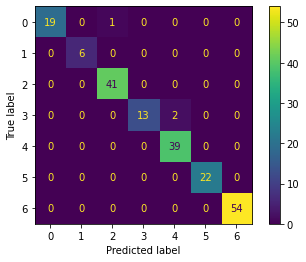

In [ ]:
cm = tf.math.confusion_matrix(Y_testCK, y_predCK)
ConfusionMatrixDisplay.from_predictions(Y_testCK, y_predCK)
plt.show()

10/10 [==============================] - 3s 278ms/step
              precision    recall  f1-score   support

           0       0.17      0.15      0.16        40
           1       0.06      0.06      0.06        16
           2       0.12      0.13      0.13        53
           3       0.14      0.14      0.14        22
           4       0.22      0.23      0.22        62
           5       0.07      0.08      0.08        25
           6       0.25      0.23      0.24        74

    accuracy                           0.17       292
   macro avg       0.15      0.15      0.15       292
weighted avg       0.17      0.17      0.17       292



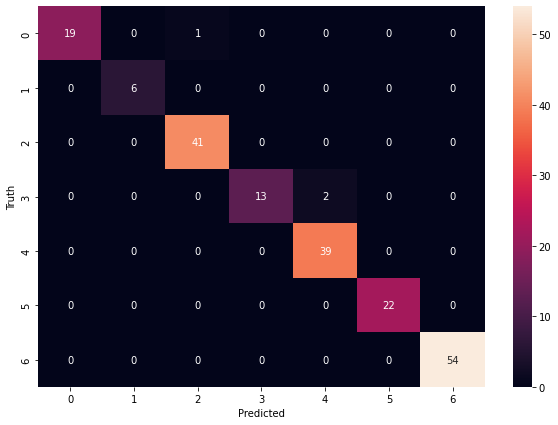

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def performance_metrics(model, test):
    y_pred = new_modelCK.predict(test)
    y_result = []
    for p in y_pred:
        y_result.append(np.argmax(p))
    
    y_actual = []
    for i in range(len(test)):
        for p in test[i][1]:
            y_actual.append(np.argmax(p))
    
    print(classification_report(y_actual, y_result))
    
    

    plt.figure(figsize = (10, 7))
    sn.heatmap(cm, annot = True, fmt = 'd')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')


performance_metrics(new_modelCK, valid_dataset)

# **RAF Dataset**

In [23]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/RAF-DB.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [35]:
XrafTrain= [] #empty list of dataset
dataset_path = '/content/dataset/aligned/train/train_images'
for file_name in os.listdir (dataset_path):
  img = cv2.imread(os.path.join (dataset_path, file_name))
  img = cv2.resize (img, (128,128))
  XrafTrain.append (img)


XrafTrain = np.array (XrafTrain)
print (XrafTrain.shape) 

(12271, 128, 128, 3)


In [36]:
labelsTraining = pd.read_csv('/content/dataset/train_labels.csv')

In [37]:
yTrain = labelsTraining.iloc[:, -1]

In [38]:
XrafTest= [] #empty list of dataset
dataset_path = '/content/dataset/aligned/test/test_images'
for file_name in os.listdir (dataset_path):
  img = cv2.imread(os.path.join (dataset_path, file_name))
  img = cv2.resize (img, (128,128))
  XrafTest.append (img)

  
XrafTest = np.array (XrafTest)
print (XrafTest.shape) 

(3068, 128, 128, 3)


In [39]:
labelsTesting = pd.read_csv('/content/dataset/test_labels.csv')

In [40]:
yTest = labelsTesting.iloc[:, -1]

In [26]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True,
                                   rotation_range = 20,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2
)

# dls = ImageDataLoaders.from_csv(
#     path='/content/dataset/aligned',
#     csv_fname='/content/dataset/train_labels.csv',
#     fn_col=0,
#     suff='.tif',
#     folder='train',
#     label_col=1,
# )

train_generator = datagen_train.flow_from_directory('/content/dataset/aligned/train/',
                                                batch_size = 128,
                                                target_size=(128, 128),
                                                shuffle=True,
                                                color_mode='rgb',
                                                class_mode='categorical')


datagen_test = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

test_generator = datagen_train.flow_from_directory('/content/dataset/aligned/test/',
                                                batch_size = 128,
                                                target_size=(128, 128),
                                                shuffle=True,
                                                color_mode='rgb',
                                                class_mode='categorical')


Found 12271 images belonging to 1 classes.
Found 3068 images belonging to 1 classes.


In [41]:
new_modelRaf = Sequential()


modelraf = tf.keras.applications.VGG16(include_top = False, input_shape = (128,128,3), weights = 'imagenet', pooling = 'avg')

# for layer in modelCK.layers:
#   layer.trainable = False


for layer in modelraf.layers[:-5]:
  layer.trainable = False


# model.summary()

# batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
# for i in range(170):
#     if i not in batch_norm_indices:
#         modelCK.layers[i].trainable = False


new_modelRaf.add(modelraf)

In [42]:
from keras.regularizers import l2
from tensorflow.keras import regularizers

new_modelRaf.add(Flatten())
# new_modelCK.add(BatchNormalization())
# new_modelCK.add(Dropout(0.25))
new_modelRaf.add(Dense(64,kernel_regularizer=l2(0.01), activation='relu'))
new_modelRaf.add(BatchNormalization())
new_modelRaf.add(Dropout(0.4))
new_modelRaf.add(Dense(64,kernel_regularizer=l2(0.01), activation='relu'))
new_modelRaf.add(BatchNormalization())
new_modelRaf.add(Dropout(0.4))


# new_modelCK.add(Dense(64,kernel_regularizer=l2(0.01), activation='relu'))
# new_modelCK.add(BatchNormalization())
# new_modelCK.add(Dropout(0.25))
# new_modelCK.add(Dense(64,kernel_regularizer=l2(0.01), activation='relu'))
# new_modelCK.add(BatchNormalization())
# new_modelCK.add(Dropout(0.25))
new_modelRaf.add(Dense(7, activation='softmax'))

In [43]:
from keras.optimizers import SGD
from keras.optimizers import Adam
adam = keras.optimizers.Adam(learning_rate=0.0001)
opt = SGD(learning_rate=0.001)
new_modelRaf.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

In [44]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              verbose=1,
                              patience=10,
                              min_lr=0.000001,
                              min_delta=0.1,
                              factor=0.2
                             )

In [45]:
earlystopping = EarlyStopping(monitor='val_accuracy', 
                              mode='max', 
                              verbose=1, 
                              patience=20
                             )

In [ ]:
historyRaf = new_modelRaf.fit(XrafTrain, yTrain, epochs = 100, callbacks=[reduce_lr, earlystopping], shuffle = True)

# **KDEF Dataset**

In [48]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/KDEFDataset.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [82]:
DatadirectoryKDEF = "KDEF/"

In [83]:
CategoriesKDEF = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

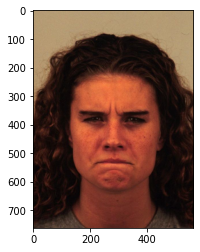

In [84]:
for category in CategoriesKDEF:
  path = os.path.join(DatadirectoryKDEF, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img))
    plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
    plt.show()
    break
  break

<function matplotlib.pyplot.show(*args, **kw)>

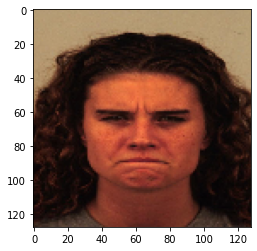

In [85]:
img_size = 128
newArray = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(newArray, cv2.COLOR_BGR2RGB))
plt.show

In [86]:
from types import new_class

training_DataKDEF = []
def create_training_data():
  for category in CategoriesKDEF:
    path = os.path.join(DatadirectoryKDEF, category)
    class_num = CategoriesKDEF.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        newArray = cv2.resize(img_array, (img_size, img_size))
        training_DataKDEF.append([newArray, class_num])
      except Exception as e:
        pass

create_training_data()

In [87]:
XKDEF = []
yKDEF = []
for features, label in training_DataKDEF:

  XKDEF.append(features)
  yKDEF.append(label)


XKDEF = np.array(XKDEF).reshape(-1, img_size, img_size, 3)

In [88]:
XKDEF = XKDEF / 255.0

In [89]:
from sklearn.model_selection import train_test_split
X_trainKDEF,X_testKDEF,Y_trainKDEF,Y_testKDEF = train_test_split(XKDEF,yKDEF,test_size=.2,random_state=0)

In [71]:
datagen_trainKDEF = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True,
                                   rotation_range = 10,
                                   zoom_range = 0.1,
                                   shear_range = 0.1,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   validation_split = 0.2
)


train_generatorKDEF = datagen_trainKDEF.flow_from_directory('/content/KDEF',
                                                batch_size = 128,
                                                target_size=(128, 128),
                                                shuffle=True,
                                                color_mode='rgb',
                                                subset = 'training',
                                                class_mode='categorical')


datagen_validKDEF = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

valid_generatorKDEF = datagen_trainKDEF.flow_from_directory('/content/KDEF',
                                                batch_size = 128,
                                                target_size=(128, 128),
                                                shuffle=True,
                                                subset = 'validation',
                                                color_mode='rgb',
                                                class_mode='categorical')

# datagen_test = ImageDataGenerator(rescale=1./255)

# test_generator = datagen_train.flow_from_directory('/content/KDEF',
#                                                 batch_size = 128,
#                                                 target_size=(128, 128),
#                                                 shuffle=True,
#                                                 color_mode='rgb',
#                                                 class_mode='categorical')

Found 2352 images belonging to 7 classes.
Found 586 images belonging to 7 classes.


In [72]:
new_modelKDEF = Sequential()


modelKDEF = tf.keras.applications.VGG16(include_top = False, input_shape = (128,128,3), weights = 'imagenet', pooling = 'avg')

# for layer in modelCK.layers:
#   layer.trainable = False


for layer in modelKDEF.layers[:-5]:
  layer.trainable = False


# model.summary()

# batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
# for i in range(170):
#     if i not in batch_norm_indices:
#         modelCK.layers[i].trainable = False


new_modelKDEF.add(modelKDEF)

In [73]:
from keras.regularizers import l2
from tensorflow.keras import regularizers

new_modelKDEF.add(Flatten())
# new_modelCK.add(BatchNormalization())
# new_modelCK.add(Dropout(0.25))
new_modelKDEF.add(Dense(64,kernel_regularizer=l2(0.01), activation='relu'))
new_modelKDEF.add(BatchNormalization())
new_modelKDEF.add(Dropout(0.4))
new_modelKDEF.add(Dense(64,kernel_regularizer=l2(0.01), activation='relu'))
new_modelKDEF.add(BatchNormalization())
new_modelKDEF.add(Dropout(0.4))


# new_modelCK.add(Dense(64,kernel_regularizer=l2(0.01), activation='relu'))
# new_modelCK.add(BatchNormalization())
# new_modelCK.add(Dropout(0.25))
# new_modelCK.add(Dense(64,kernel_regularizer=l2(0.01), activation='relu'))
# new_modelCK.add(BatchNormalization())
# new_modelCK.add(Dropout(0.25))
new_modelKDEF.add(Dense(7, activation='softmax'))

In [74]:
from keras.optimizers import SGD
from keras.optimizers import Adam
adam = keras.optimizers.Adam(learning_rate=0.0001)
opt = SGD(learning_rate=0.001)
new_modelKDEF.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

In [75]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              verbose=1,
                              patience=10,
                              min_lr=0.000001,
                              min_delta=0.1,
                              factor=0.2
                             )

In [76]:
earlystopping = EarlyStopping(monitor='val_accuracy', 
                              mode='max', 
                              verbose=1, 
                              patience=20
                             )

In [78]:
historyKDEF = new_modelKDEF.fit(train_generatorKDEF, validation_data = valid_generatorKDEF, epochs = 60, callbacks=[reduce_lr, earlystopping], shuffle = True)

Epoch 1/60
19/19 [==============================] - 26s 1s/step - loss: 1.5792 - accuracy: 0.4362 - val_loss: 1.5815 - val_accuracy: 0.3857 - lr: 1.0000e-04
Epoch 2/60
19/19 [==============================] - 26s 1s/step - loss: 1.4443 - accuracy: 0.4821 - val_loss: 1.6154 - val_accuracy: 0.4966 - lr: 1.0000e-04
Epoch 3/60
19/19 [==============================] - 26s 1s/step - loss: 1.3000 - accuracy: 0.5238 - val_loss: 1.4128 - val_accuracy: 0.4266 - lr: 1.0000e-04
Epoch 4/60
19/19 [==============================] - 26s 1s/step - loss: 1.2246 - accuracy: 0.5668 - val_loss: 1.2720 - val_accuracy: 0.5137 - lr: 1.0000e-04
Epoch 5/60
19/19 [==============================] - 26s 1s/step - loss: 1.0968 - accuracy: 0.5948 - val_loss: 1.1382 - val_accuracy: 0.6689 - lr: 1.0000e-04
Epoch 6/60
19/19 [==============================] - 26s 1s/step - loss: 1.0420 - accuracy: 0.6297 - val_loss: 1.1714 - val_accuracy: 0.6126 - lr: 1.0000e-04
Epoch 7/60
19/19 [==============================] - 26s 1s

In [79]:
scoreKDEF = new_modelKDEF.evaluate(valid_generatorKDEF)

5/5 [==============================] - 5s 974ms/step - loss: 0.2794 - accuracy: 0.9078


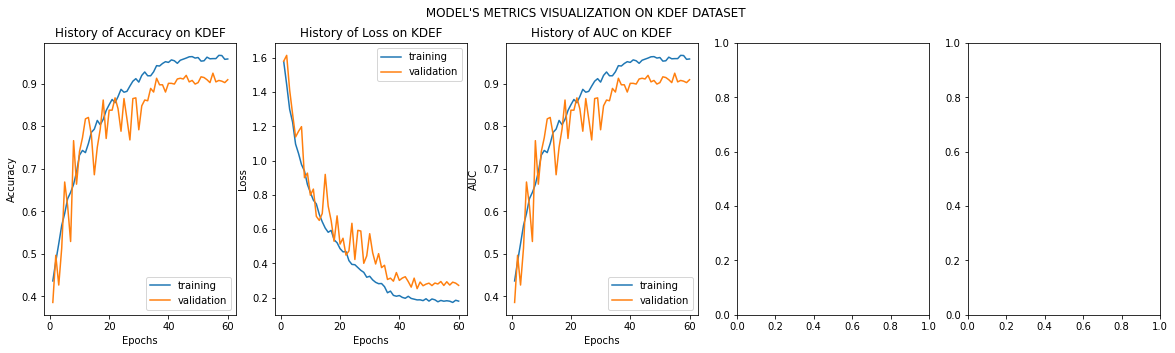

In [80]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ON KDEF DATASET")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy on KDEF')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss on KDEF')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC on KDEF')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    

    plt.show()
    

Train_Val_Plot(historyKDEF.history['accuracy'],historyKDEF.history['val_accuracy'],
               historyKDEF.history['loss'],historyKDEF.history['val_loss'],
               historyKDEF.history['accuracy'],historyKDEF.history['val_accuracy']
              )

5/5 [==============================] - 5s 1s/step
              precision    recall  f1-score   support

           0       0.16      0.15      0.16        84
           1       0.09      0.08      0.09        84
           2       0.12      0.12      0.12        84
           3       0.13      0.13      0.13        84
           4       0.12      0.13      0.12        84
           5       0.16      0.17      0.16        83
           6       0.16      0.16      0.16        83

    accuracy                           0.13       586
   macro avg       0.13      0.13      0.13       586
weighted avg       0.13      0.13      0.13       586



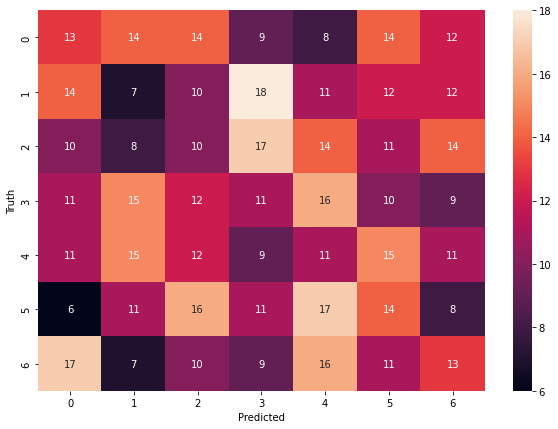

In [81]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def performance_metrics(model, test):
    y_pred = new_modelKDEF.predict(test)
    y_result = []
    for p in y_pred:
        y_result.append(np.argmax(p))
    
    y_actual = []
    for i in range(len(test)):
        for p in test[i][1]:
            y_actual.append(np.argmax(p))
    
    print(classification_report(y_actual, y_result))
    
    
    cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

    plt.figure(figsize = (10, 7))
    sn.heatmap(cm, annot = True, fmt = 'd')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')


performance_metrics(new_modelKDEF, valid_generatorKDEF)

In [90]:
feature_extractionKDEF = new_modelKDEF.predict(X_trainKDEF)

74/74 [==============================] - 6s 59ms/step


In [91]:
featuresKDEF = feature_extractionKDEF.reshape(feature_extractionKDEF.shape[0], -1)

In [92]:
X_for_SVMKDEF = featuresKDEF

In [93]:
from sklearn import svm
clfKDEF = svm.SVC()
clfKDEF.fit(X_for_SVMKDEF, Y_trainKDEF)

SVC()

In [94]:
X_Test_featureKDEF = new_modelKDEF.predict(X_testKDEF)

19/19 [==============================] - 2s 94ms/step


In [95]:
X_Test_New_FeaturesKDEF = X_Test_featureKDEF.reshape(X_Test_featureKDEF.shape[0], -1)

In [96]:
y_predKDEF = clfKDEF.predict(X_Test_New_FeaturesKDEF)

In [97]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(Y_testKDEF, y_predKDEF)*100)

Accuracy: 74.82993197278913


# **TESTING**

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np
import  numpy  as  np
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import matplotlib.pyplot as plt

img_path = '/content/test/happy/im100.png'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_data = tf.keras.utils.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)




In [ ]:
print(img_data.shape)

(1, 128, 128, 3)


In [ ]:
testing = new_modelCK.predict(img_data)

1/1 [==============================] - 0s 42ms/step


In [ ]:
Testing_fixed = testing.reshape(testing.shape[0], -1)

In [ ]:
testing[0]

array([0.0000000e+00, 0.0000000e+00, 2.2356837e-36, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.0000000e+00], dtype=float32)

In [ ]:
y_predCKTest = clfCK.predict(Testing_fixed)

In [ ]:
print(y_predCKTest)

[6]


In [ ]:
np.argmax(testing)

6